In [1]:
import poppy
import jax

In [2]:
# FINITE FIELD LATTICE BASED KEY ENCAPSULATION.
p = 65521 # is the 16 bit field characteristic.
n = 4 # is the field degree. {2,3,4}
f = poppy.field(p,n) # is the finite field.
k = 16 # is the square root of the number of bytes in the message. {4,8,16}
b = 1 # is the number of k*k byte messages.
psd = poppy.SEED # is the public seed.
ssd = (908235,3209,4580,1,583981) # are secret seeds.

In [3]:
def uniform(seed):
  sample = jax.random.randint(jax.random.key(seed), (b,k,k,n), 0,p, dtype = poppy.DTYPE)
  return sample
def normal(seed):
  bits = jax.random.bits(jax.random.key(seed), shape = (b*k*k*n,1), dtype = jax.numpy.uint8)
  bitsream = jax.numpy.unpackbits(bits, axis = 1).reshape((b*k*k*n,2,4))
  sample = jax.numpy.sum(bitsream, axis = 2, dtype = poppy.DTYPE)
  return jax.numpy.subtract(sample[:,0],sample[:,1]).reshape((b,k,k,n))%p

def base(a,b):
  return jax.numpy.tensordot(a,b, axes = ([-1],[0]))%p
def trace(a):
  return jax.numpy.trace(a, axis1=-2, axis2=-1)%p

def compress(a):
  return jax.numpy.astype(a,jax.numpy.uint16)
def decompress(a):
  return jax.numpy.astype(a,poppy.DTYPE)

def dot(x,y):
  return jax.numpy.tensordot(x,y, axes = ([1,3],[0,2])).swapaxes(1,2)%p
def mul(a,b):
  return jax.vmap(dot)(a,b)
def add(a,b):
  return (a+b)%p
def sub(a,b):
  return (a-b)%p

def encode(M):
  return (jax.numpy.rint((p/256)*M.reshape((b,k,k,1,1))))*(f.DUAL[0].reshape((1,1,1,n,n)))%p
def decode(MU):
  return jax.numpy.astype(jax.numpy.rint(256/p*trace(MU))%256, jax.numpy.uint8).reshape((b,k,k))

@jax.jit
def keygen():
  sk = base(normal(ssd[0]),f.BASIS.swapaxes(1,2)) # b k k n n secret key.
  e = base(normal(ssd[1]),f.DUAL)                 # b k k n n error.
  pk1 = base(uniform(psd),f.BASIS)                # b k k n n public key.
  pk2 = add(mul(pk1,sk),e)                        # b k k n n public key.
  ek = (compress(pk2),psd)  # Encapsulation key.
  dk = compress(sk)         # Decapsulation key.
  return sk,e,pk1,pk2, ek,dk

@jax.jit
def encrypt(M,ek):
  pk2,psd = ek
  pk1 = base(uniform(psd),f.BASIS)                     # b k k n n public key.
  r = base(normal(ssd[2]),f.BASIS)                     # b k k n n randomness.
  e1 = base(normal(ssd[3]),f.DUAL.swapaxes(1,2))       # b k k n n error.
  e2 = base(normal(ssd[4]),f.DUAL)                     # b k k n n error.
  pk3 = add(mul(pk1.swapaxes(1,2),r),e1)               # b k k n n public key.
  MU = encode(M)                                       # b k k n n message.
  ct = add(mul(decompress(pk2).swapaxes(1,2),r),e2+MU) # b k k n n cipher text.
  c = (compress(pk3),compress(ct))  # Ciphertext.
  return r,e1,e2,pk3,MU,ct, c

@jax.jit
def decrypt(c,dk):
  pk3,ct = c
  mu = sub(decompress(ct),mul(decompress(dk).swapaxes(1,2),decompress(pk3)))
  m = decode(mu)
  return mu, m

M = jax.numpy.tile(jax.numpy.arange(k*k, dtype = jax.numpy.uint8),b).reshape((b,k,k)) # Message.
sk,e,pk1,pk2, ek,dk = keygen()
r,e1,e2,pk3,MU,ct, c = encrypt(M,ek)
mu, m = decrypt(c,dk)

print(f'First {len(M[0].ravel())} byte message:')
print(M[0])
print('Decryption error:')
print((M-m)[0])

First 256 byte message:
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
 [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
 [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175]
 [176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191]
 [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207]
 [208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223]
 [224 225 226 227 228 229 230 231 232 

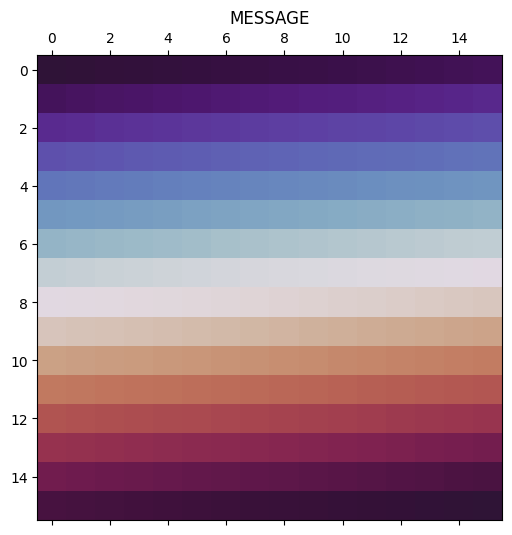

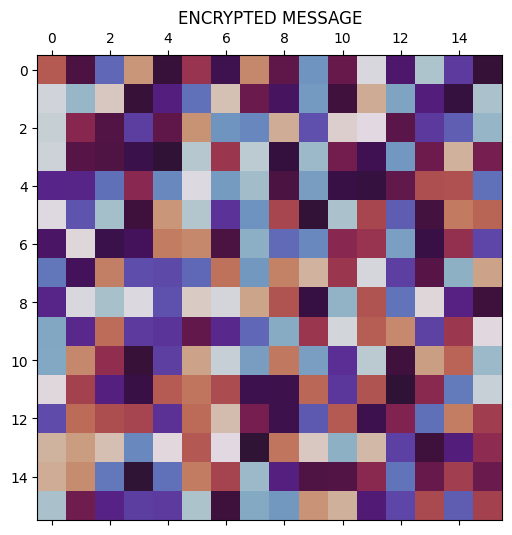

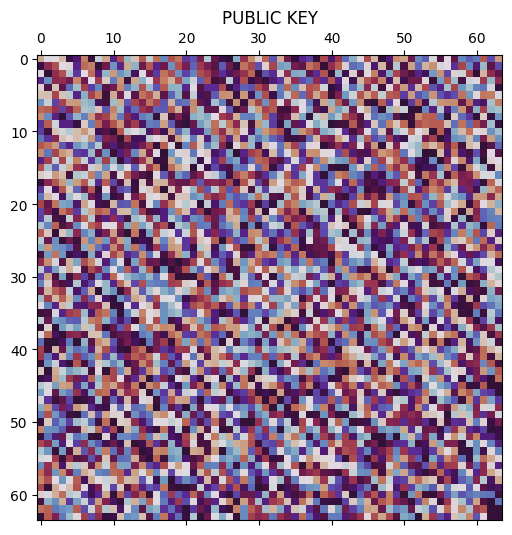

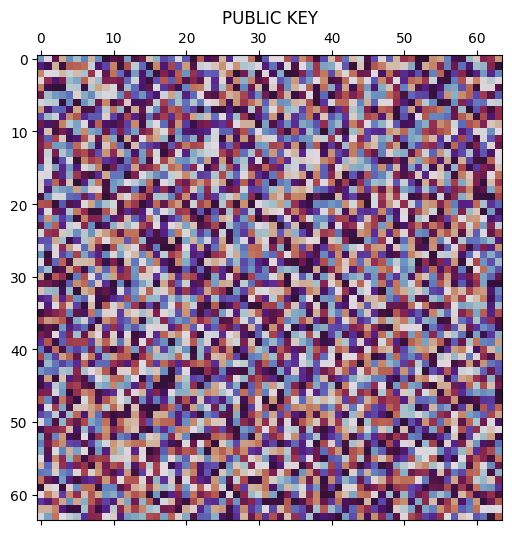

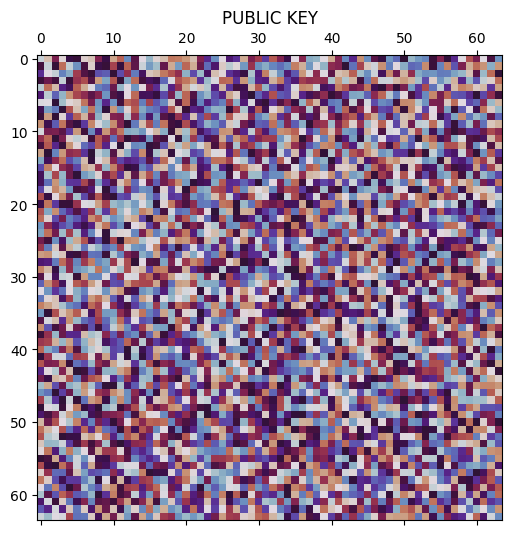

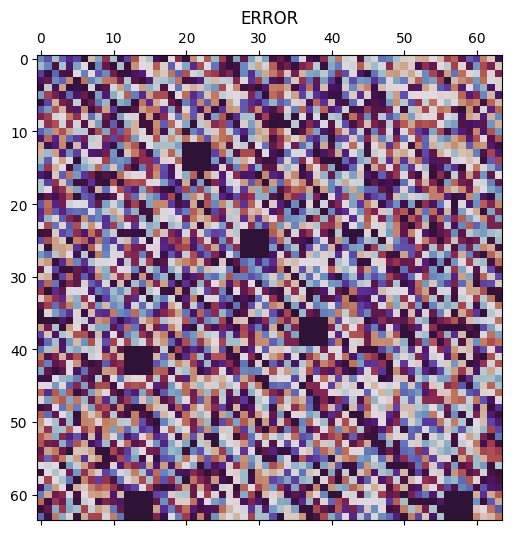

In [4]:
poppy.plot(poppy.tracemod(MU,p).reshape((-1,k)), title = 'MESSAGE')
poppy.plot(poppy.tracemod(ct,p).reshape((-1,k)), title = 'ENCRYPTED MESSAGE')
poppy.plot(pk1.swapaxes(2,3).reshape((-1,k*n)), title = 'PUBLIC KEY')
poppy.plot(pk2.swapaxes(2,3).reshape((-1,k*n)), title = 'PUBLIC KEY')
poppy.plot(pk3.swapaxes(2,3).reshape((-1,k*n)), title = 'PUBLIC KEY')
poppy.plot(e.swapaxes(2,3).reshape((-1,k*n)), title = 'ERROR')

In [5]:
p = 293
n = 12
f = poppy.field(p,n)

print(poppy.tracemod(jax.numpy.tensordot(f.BASIS,f.DUAL, axes = ([2],[1])).swapaxes(1,2),p))

[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


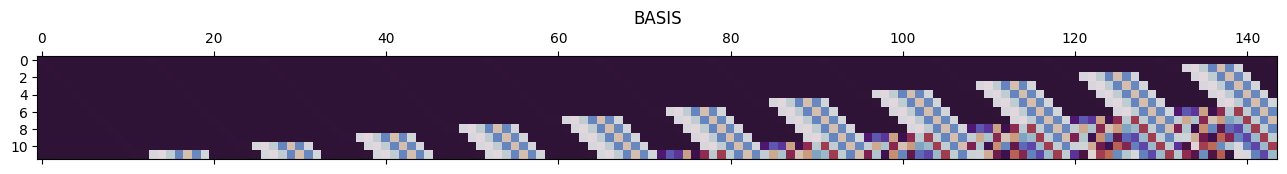

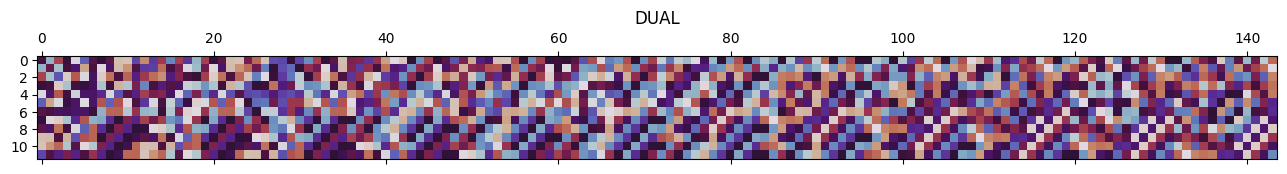

In [6]:
poppy.plot(f.BASIS, title = 'BASIS')
poppy.plot(f.DUAL, title = 'DUAL')

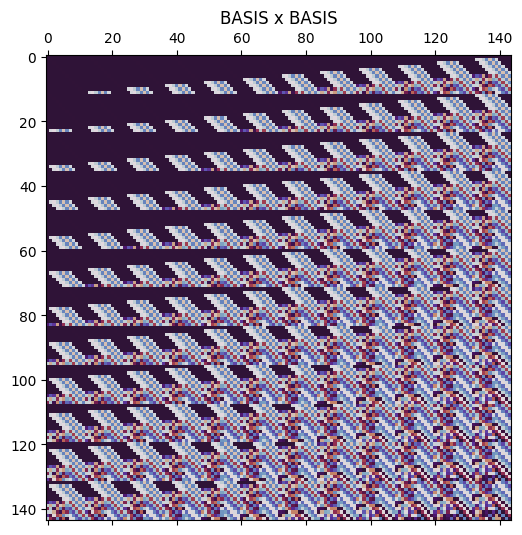

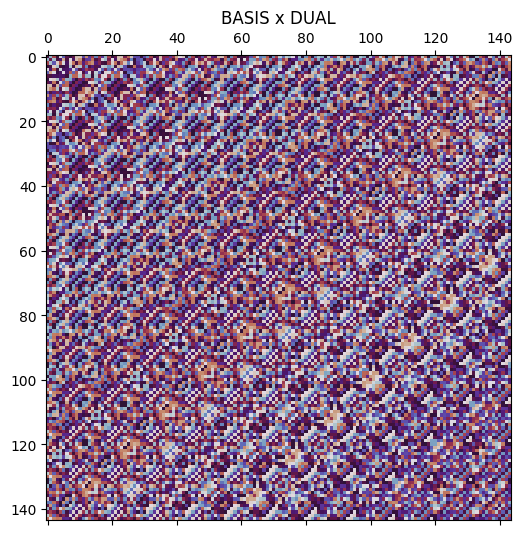

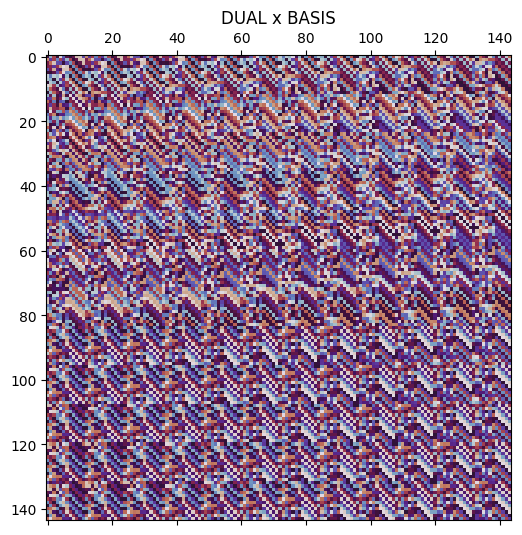

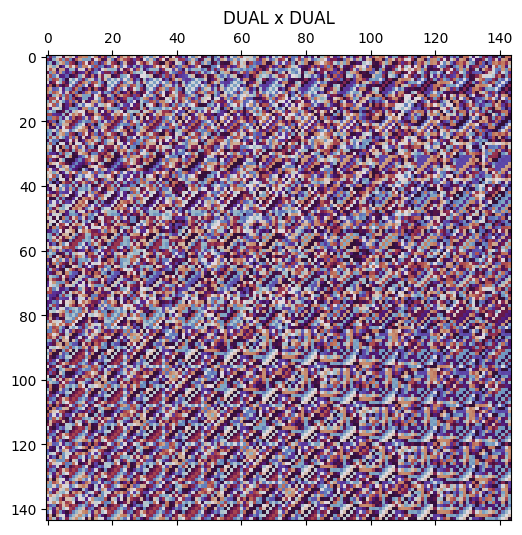

In [7]:
poppy.plot(jax.numpy.tensordot(f.BASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'BASIS x BASIS')
poppy.plot(jax.numpy.tensordot(f.BASIS,f.DUAL, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'BASIS x DUAL')
poppy.plot(jax.numpy.tensordot(f.DUAL,f.BASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'DUAL x BASIS')
poppy.plot(jax.numpy.tensordot(f.DUAL,f.DUAL, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'DUAL x DUAL')

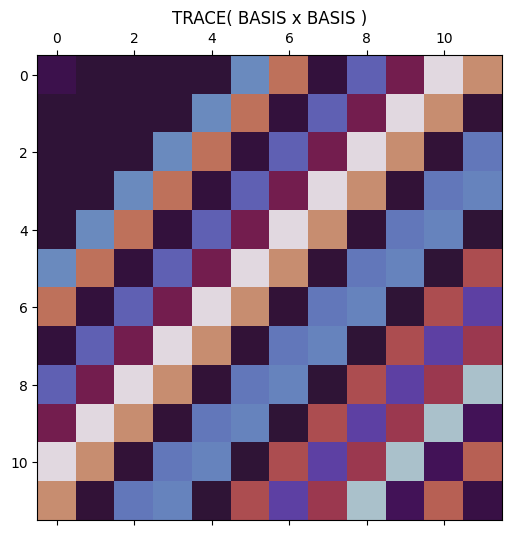

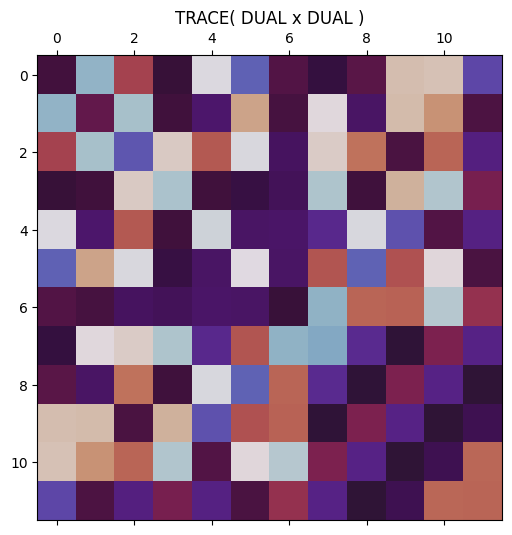

In [8]:
poppy.plot(poppy.tracemod(jax.numpy.tensordot(f.BASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2)%p,p), title = 'TRACE( BASIS x BASIS )')
poppy.plot(poppy.tracemod(jax.numpy.tensordot(f.DUAL,f.DUAL, axes = ([2],[1])).swapaxes(1,2)%p,p), title = 'TRACE( DUAL x DUAL )')